In [1]:
import numpy as np
import pandas as pd
import json

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
# Import supplementary visualizations code visuals.py
import visuals as vs
#from mpl_toolkits import mplot3d
import importlib

# 1. Load  Data

In [2]:
# Load main dataset
main_dataset = pd.read_csv('data/main_dataset.csv')

# 2. Drop Irrelevant Features

In [3]:
def drop_irrelevant_features(dataset):
    features = ['datetime']

    for feature in features:
        if  feature in dataset.columns:
            dataset = dataset.drop(feature, axis=1)
            
    return dataset

#Remove unused features
main_dataset = drop_irrelevant_features(main_dataset)

# 2. Sample Construction

In [4]:
class Sample:
    ''' Class for Sample Creation'''
    
    def __init__(self, dataset):
        '''Initialize dataset'''
        self.dataset = dataset   

            
    def extract_record_with_range(self, values):
        ''' Extract first record within range'''
        
        dataset = self.dataset
        smsin_high, smsin_low = values[0], values[1]
        smsout_high, smsout_low = values[2], values[3]
        callin_high, callin_low = values[4], values[5] 
        callout_high, callout_low =  values[6], values[7]    
        internet_high, internet_low = values[8], values[9]             
        
        records = dataset[
             (dataset.internet > internet_low) & (dataset.internet < internet_high) & 
             (dataset.callout > callout_low) & (dataset.callout < callout_high) & 
             (dataset.callin > callin_low) & (dataset.callin < callin_high) & 
             (dataset.smsout > smsout_low) & (dataset.smsout < smsout_high) & 
             (dataset.smsin > smsin_low) & (dataset.smsin < smsin_high)]
    
        if len(records) < 1:
            return None
        
        #print(records)
        return records.iloc[0]
        
    
    def  get_percentile_upper_limit(self, percentile, step_size):
        ''' Useful for filtering purposes '''
        
        # Fit Range
        if (percentile + step_size) >= 100:
            return 99
        elif (percentile + step_size) < step_size:
            return step_size
        
        return (percentile + step_size)
        
        
    def calc_percentile_val(self, position, dataset):
        ''' Extract corresponding value for the position '''
        return np.percentile(dataset, position)
    
    def get_percentile_values(self, percentile, step_size):
        ''' Returns a vector of corresponding high/low values '''
        values = []
        dataset = self.dataset
        
        p_upper = self.get_percentile_upper_limit(percentile, step_size)
        p_lower = percentile
        
        # Calculate values
        smsin_high = self.calc_percentile_val(p_upper, dataset['smsin'])
        smsin_low = self.calc_percentile_val(p_lower, dataset['smsin'])
        
        smsout_high = self.calc_percentile_val(p_upper, dataset['smsout'])
        smsout_low = self.calc_percentile_val(p_lower, dataset['smsout'])
        
        callin_high = self.calc_percentile_val(p_upper, dataset['callin'])
        callin_low = self.calc_percentile_val(p_lower, dataset['callin'])
        
        callout_high = self.calc_percentile_val(p_upper, dataset['callout'])
        callout_low = self.calc_percentile_val(p_lower, dataset['callout'])
        
        internet_high = self.calc_percentile_val(p_upper, dataset['internet'])
        internet_low = self.calc_percentile_val(p_lower, dataset['internet'])
        
        # store values
        values.append(smsin_high)
        values.append(smsin_low)
        values.append(smsout_high)
        values.append(smsout_low)
        values.append(callin_high)
        values.append(callin_low)
        values.append(callout_high)
        values.append(callout_low)
        values.append(internet_high)
        values.append(internet_low)
        
        return values
        
        
    def construct_sample(self, start_percentile):
        p = start_percentile
        sample = pd.DataFrame(columns= ["CellID", "countrycode", "smsin",
                                        "smsout", "callin", "callout", "internet"])
        step_size = 5

        # Looking at a subset of 5 records per sample
        for i in range(0, step_size):  
            
            if p > step_size:

                # Get percentile values
                values = self.get_percentile_values(p, step_size)
                
                # Extract a record from the filter result
                record = self.extract_record_with_range(values)
                
                #print(type(record))
                if(record is not None):
                    sample = sample.append(record)

                # Update percentile step count
                p = p - step_size  
                
        #print(sample)
        return sample
                
    def get_samples(self):
        ''' Get likely and unlikely RCS subscriber samples'''
        
        # Percentiles 
        start_p_likely = 92
        start_p_unlikely = 32 
        
        # Extract Likely RCS Customer Sample
        likely_sample = self.construct_sample(start_p_likely)
        
        # Extract Unlikely RCS Customer Sample 
        unlikely_sample = self.construct_sample(start_p_unlikely)
        
        return likely_sample, unlikely_sample
    

In [5]:
sample = Sample(main_dataset)
sample_likely, sample_unlikely = sample.get_samples()

### Likely Sample

In [6]:
sample_likely



,CellID,countrycode,smsin,smsout,callin,callout,internet
4308,4352.0,39.0,81.9838,64.3447,73.8145,65.9516,1806.9842
76199,4989.0,39.0,40.3979,37.0648,45.1203,49.5017,1087.1416
74959,3751.0,39.0,27.9552,20.6433,24.7905,31.5422,701.5989
84038,2733.0,39.0,19.4405,17.4271,19.6668,24.8393,498.8634
75486,4278.0,39.0,15.7487,14.9308,13.5218,15.8724,446.0121


### Unlikely Sample

In [7]:
sample_unlikely


,CellID,countrycode,smsin,smsout,callin,callout,internet
7762,7848.0,39.0,2.9440,2.2726,1.9023,1.8718,104.5199
3978,4022.0,39.0,2.0188,2.0544,1.1605,1.3302,81.5893
69755,8581.0,39.0,1.3320,1.5861,0.8501,1.1218,66.0231
33,34.0,39.0,0.9476,0.9502,0.7321,0.6431,46.7024
131,135.0,39.0,0.6597,0.6859,0.3853,0.4431,35.5341


### Concatenate samples

In [8]:
samples = pd.concat([sample_likely, sample_unlikely])
samples

,CellID,countrycode,smsin,smsout,callin,callout,internet
4308,4352.0,39.0,81.9838,64.3447,73.8145,65.9516,1806.9842
76199,4989.0,39.0,40.3979,37.0648,45.1203,49.5017,1087.1416
74959,3751.0,39.0,27.9552,20.6433,24.7905,31.5422,701.5989
84038,2733.0,39.0,19.4405,17.4271,19.6668,24.8393,498.8634
75486,4278.0,39.0,15.7487,14.9308,13.5218,15.8724,446.0121
7762,7848.0,39.0,2.9440,2.2726,1.9023,1.8718,104.5199
3978,4022.0,39.0,2.0188,2.0544,1.1605,1.3302,81.5893
69755,8581.0,39.0,1.3320,1.5861,0.8501,1.1218,66.0231
33,34.0,39.0,0.9476,0.9502,0.7321,0.6431,46.7024
131,135.0,39.0,0.6597,0.6859,0.3853,0.4431,35.5341


In [9]:
main_dataset.head()

,CellID,countrycode,smsin,smsout,callin,callout,internet
0,1,39,1.7322,1.1047,0.5919,0.4020,57.7729
1,2,39,1.7334,1.0880,0.6020,0.4109,57.8875
2,3,39,1.7348,1.0701,0.6128,0.4203,58.0095
3,4,39,1.7284,1.1533,0.5627,0.3763,57.4408
4,5,39,1.5530,1.0439,0.5110,0.3503,52.1497


# 3. Preprocessing

## Scaling

### Scatter Matrix (Before Scaling)

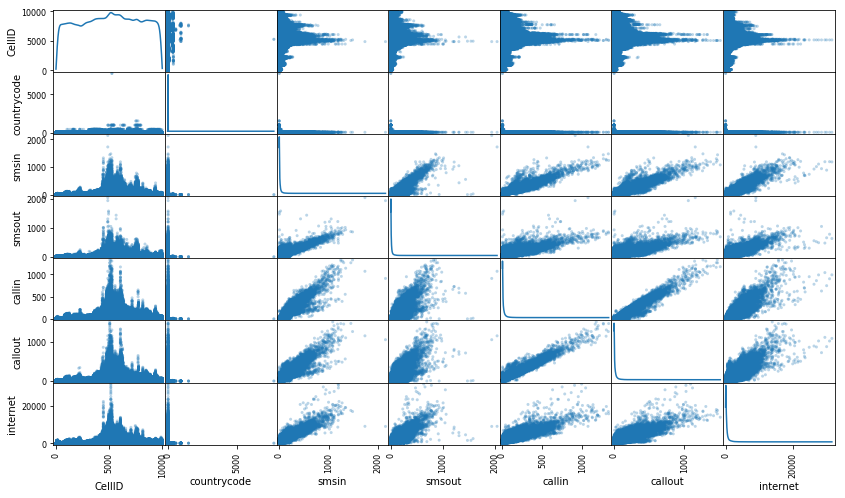

In [10]:
pd.plotting.scatter_matrix(main_dataset, alpha=0.3, figsize= (14, 8), diagonal = 'kde');

In [11]:
# Apply natural logarithm
non_zero_constant = 1 # for log transformation or zero values
log_data = np.log(main_dataset + non_zero_constant)

### Scatter Matrix (After Scaling)

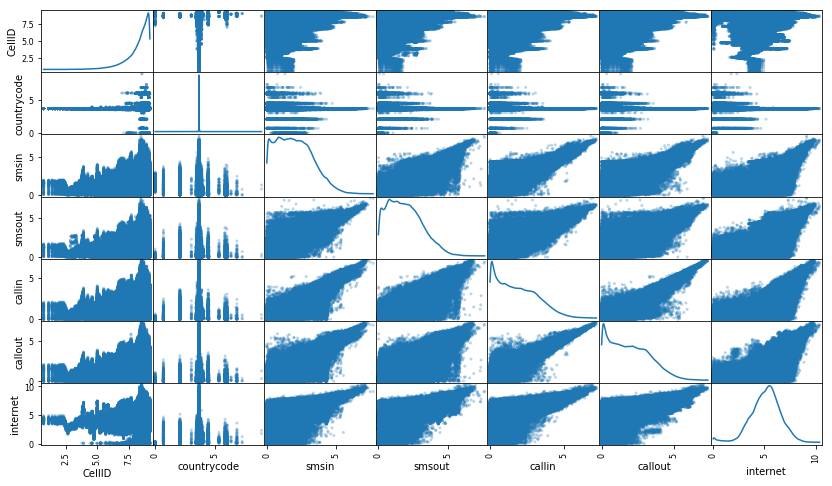

In [12]:
pd.plotting.scatter_matrix(log_data, alpha=0.3, figsize= (14, 8), diagonal = 'kde');

In [13]:
# Scale samples
log_samples = np.log(samples)
log_samples

,CellID,countrycode,smsin,smsout,callin,callout,internet
4308,8.378391,3.663562,4.406522,4.164255,4.301555,4.188921,7.499415
76199,8.514991,3.663562,3.698778,3.612668,3.809332,3.902007,6.991307
74959,8.229778,3.663562,3.330603,3.027391,3.210461,3.451326,6.553362
84038,7.913155,3.663562,2.967359,2.858026,2.978932,3.212427,6.212332
75486,8.361241,3.663562,2.756758,2.703426,2.604303,2.764582,6.100346
7762,8.968014,3.663562,1.079769,0.820925,0.643064,0.626901,4.649377
3978,8.299535,3.663562,0.702503,0.719984,0.148851,0.285329,4.401698
69755,9.057306,3.663562,0.286682,0.461278,-0.162401,0.114935,4.190005
33,3.526361,3.663562,-0.053823,-0.051083,-0.311838,-0.441455,3.843796
131,4.905275,3.663562,-0.415970,-0.377023,-0.953733,-0.813960,3.570493


## Feature Transformation

### Explore Explained Variance

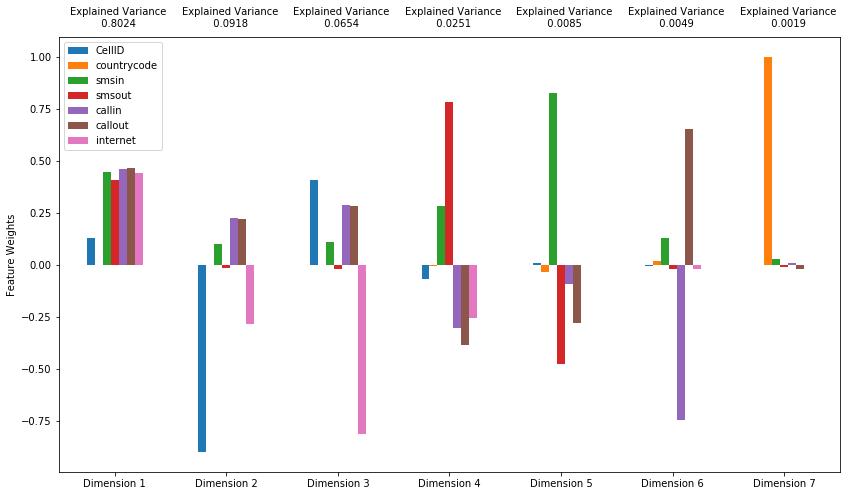

In [14]:
n_components = log_data.shape[1]

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=n_components)
pca = pca.fit(log_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(log_data, pca)

### Reduce Dimension

In [15]:

# Apply PCA by fitting the log data with only three dimensions
pca = PCA(n_components=3)
pca = pca.fit(log_data)

# Transform the log data using the PCA fit above
reduced_data = pca.transform(log_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2',  'Dimension 3'])

### Transformed Sample Data

In [16]:
# Display sample log-data after applying PCA transformation in three dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2',  'Dimension 3']))

,Dimension 1,Dimension 2,Dimension 3
0,5.2230,0.4329,-0.3124
1,4.1200,0.2193,-0.1333
2,3.0046,0.3410,-0.2223
3,2.3657,0.5858,-0.2451
4,1.8377,0.0140,-0.2253
5,-2.1260,-1.1632,-0.1137
6,-2.9167,-0.7112,-0.4629
7,-3.4229,-1.4780,-0.1598
8,-4.9818,3.4220,-2.3639
9,-5.6838,2.0020,-1.9018


# 4. Clustering (Label Definition)

### Define Clustering method

In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def do_clustering(k, _sample_size):
    global clusterer, preds, centers, sample_preds, score
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=k, random_state=42).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, sample_size =_sample_size)
    
    print("For k = {}, silhouette_score = {}".format(k,score))

### Investigate optimal number of clusters

In [19]:
sample_size = 20000
for k in range(2,10):
    do_clustering(k, sample_size)

For k = 2, silhouette_score = 0.37848201885059257
For k = 3, silhouette_score = 0.20369893864020672
For k = 4, silhouette_score = 0.15465089349871228
For k = 5, silhouette_score = 0.10464889054372502
For k = 6, silhouette_score = 0.049902623355172426
For k = 7, silhouette_score = 0.08733586128455019
For k = 8, silhouette_score = 0.06996534031890872
For k = 9, silhouette_score = 0.11540449802857344


### Create clusters

In [20]:
k = 2 # Number of clusters
s = 20000 # Sample size
do_clustering(k, s)

For k = 2, silhouette_score = 0.38028141327437287


### Visualize clusters

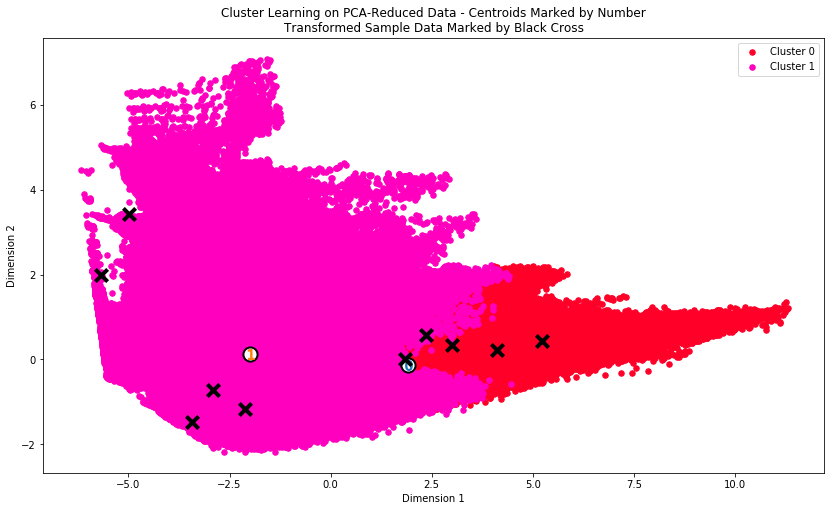

In [21]:
vs.cluster_results(reduced_data, preds, centers, pca_samples)

# 5. Cluster Validation

### Recover data

In [27]:
# Find cluster centroids
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers) - non_zero_constant

# Display the true centers
segments = ['Cluster {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = main_dataset.keys())
true_centers.index = segments
display(true_centers)

,CellID,countrycode,smsin,smsout,callin,callout,internet
Cluster 0,5829.0,39.0,16.0,13.0,14.0,16.0,344.0
Cluster 1,2362.0,39.0,2.0,2.0,1.0,2.0,78.0


### Compare predictions to truth value

Cluster 0: Active Users -> Likely to adopt RCS

Cluster 1: Non-Active and Partially Active Users -> Unlikely to adopt RCS

In [28]:
likely_group = 0
unlikely_group = 1
true_sample_preds = [likely_group, likely_group, likely_group, likely_group, likely_group, 
                    unlikely_group, unlikely_group, unlikely_group, unlikely_group, unlikely_group]

# Display the predictions on samples
for i,pred in enumerate(zip(sample_preds, true_sample_preds)):
    print("Sample point {} predicted to be in Cluster '{}' is {}".format(i, pred[0], (pred[0]==pred[1])))

Sample point 0 predicted to be in Cluster '0' is True
Sample point 1 predicted to be in Cluster '0' is True
Sample point 2 predicted to be in Cluster '0' is True
Sample point 3 predicted to be in Cluster '0' is True
Sample point 4 predicted to be in Cluster '0' is True
Sample point 5 predicted to be in Cluster '1' is True
Sample point 6 predicted to be in Cluster '1' is True
Sample point 7 predicted to be in Cluster '1' is True
Sample point 8 predicted to be in Cluster '1' is True
Sample point 9 predicted to be in Cluster '1' is True


### Extract labels and save data

In [32]:
# Change label IDs for training purposes
# 1 == Likely Customers
# 0 == Unlikely Customers
flipped_preds = [ p^1 for p in preds]

# Store labels
label = pd.Series(flipped_preds)
log_data['label'] = label
log_data[log_data.label == 1].head()
#log_data.head(n=30)

,CellID,countrycode,smsin,smsout,callin,callout,internet,label
2916,7.993282,3.688879,3.739207,3.729140,0.461782,0.410585,3.972855,1
3011,8.024862,3.688879,2.410228,2.384211,1.565005,1.622788,5.574155,1
3012,8.025189,3.688879,2.453751,2.256646,1.653531,1.806779,5.615415,1
3013,8.025516,3.688879,2.453751,2.256646,1.653531,1.806779,5.615415,1
3014,8.025843,3.688879,2.388497,2.190480,1.603420,1.745000,5.589799,1


In [33]:
#Save to csv
log_data.to_csv(path_or_buf="data/log_data.csv", index=False)

In [38]:
#reverse log_data and save to csv ...
original_data = log_data.drop(['label'], axis=1)
original_data = np.exp(original_data) - non_zero_constant
original_data['label'] = label
original_data[original_data.label==1].head()

,CellID,countrycode,smsin,smsout,callin,callout,internet,label
2916,2960.0,39.0,41.0646,40.6433,0.5869,0.5077,52.1360,1
3011,3055.0,39.0,10.1365,9.8505,3.7827,4.0672,262.5267,1
3012,3056.0,39.0,10.6319,8.5510,4.2254,5.0908,273.6273,1
3013,3057.0,39.0,10.6319,8.5510,4.2254,5.0908,273.6273,1
3014,3058.0,39.0,9.8971,7.9395,3.9700,4.7259,266.6819,1


In [39]:
# save to csv
original_data.to_csv(path_or_buf="data/original_data.csv", index=False)